## XOR Neural Network
> Griffin Davis and Sydnee Haney

In [32]:
import pandas as pd
import numpy as np
from math import cos, sin, atan
from urllib.request import urlopen, HTTPError
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier

#### Data Load

In [33]:
fr = None
try:
    fr = open('../Datasets/bitwise_operators.json', 'r')
except FileNotFoundError:
    try:
        fr = urlopen(
            'https://raw.githubusercontent.com/davisgriffin/Machine_Learning/main/Datasets/bitwise_operators.json')
    except HTTPError:
        raise Exception('Cannot read data')
data = pd.read_json(fr, orient='records')
fr.close()
data

,OP,x1,x2,y
0,AND,0,0,0
1,AND,0,0,0
2,AND,0,1,0
3,AND,1,0,0
4,AND,1,1,1
...,...,...,...,...
99995,NOR,0,0,1
99996,NOR,0,1,0
99997,NOR,0,0,1
99998,NOR,0,1,0


#### Format Data

In [34]:
le = LabelEncoder()
le.fit(data['OP']) # fit separately to invert later
data['OP'] = le.transform(data['OP'])
X = data.drop(columns='y')
y = data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2)
X_train

,OP,x1,x2
54638,4,0,1
41427,4,1,1
95165,2,1,1
84806,2,0,1
74836,1,0,1
...,...,...,...
58894,4,1,1
69645,1,1,1
58141,4,0,1
58633,4,0,0


#### Creating the Model

In [35]:
clf = MLPClassifier(hidden_layer_sizes=(10,)).fit(X_train, y_train)

#### Prediction

In [36]:
printout = X_test.copy()
printout['OP'] = le.inverse_transform(printout['OP'])
printout['y'] = y_test
printout['Prediction'] = clf.predict(X_test)
print(f'Classifier Score: {clf.score(X_test, y_test)}.')
printout

Classifier Score: 0.95125.


,OP,x1,x2,y,Prediction
26825,OR,0,1,1,1
86383,NOR,0,0,1,1
59210,XOR,1,0,1,1
97542,NOR,0,0,1,1
50324,XOR,0,1,1,1
...,...,...,...,...,...
50241,XOR,0,1,1,1
49355,XOR,1,1,0,0
93877,NOR,1,0,0,0
45325,XOR,1,1,0,0


#### Helper Functions

In [37]:
def compute_angle(pos1, pos2):
    return atan((pos2[1]-pos1[1])/(pos2[0]-pos1[0]))

def create_line(neuron1, neuron2, weight, radius):
    tol = 1e-3
    pos1 = neuron1.get_center()
    pos2 = neuron2.get_center()
    theta = compute_angle(pos1, pos2)

    offset_x = cos(theta)*radius
    offset_y = sin(theta)*radius

    new_pos1 = (pos1[0] + offset_x, pos1[1] + offset_y)
    new_pos2 = (pos2[0] - offset_x, pos2[1] - offset_y)
        
    linewidth = abs(weight)

    color = 'r'
    if weight < 0:
        color = 'b'

    linestyle = 'solid'
    if linewidth < tol:
        linestyle = 'dashed'
        color = 'black'
        linewidth = 1

    return plt.Line2D([new_pos1[0], new_pos2[0]], [new_pos1[1], new_pos2[1]], linewidth=linewidth, color=color, linestyle=linestyle)

def custom_legend():
    custom_lines = [
        plt.Line2D([0], [0], color='r', linewidth=1.5, label="Positive Weight"),
        plt.Line2D([0], [0], color='b', linewidth=1.5, label="Negative Weight"),
        plt.Line2D([0], [0], color='black', linestyle='--', linewidth=1.5, label="Negligible Weight")
    ]
    return custom_lines

#### Plot Setup

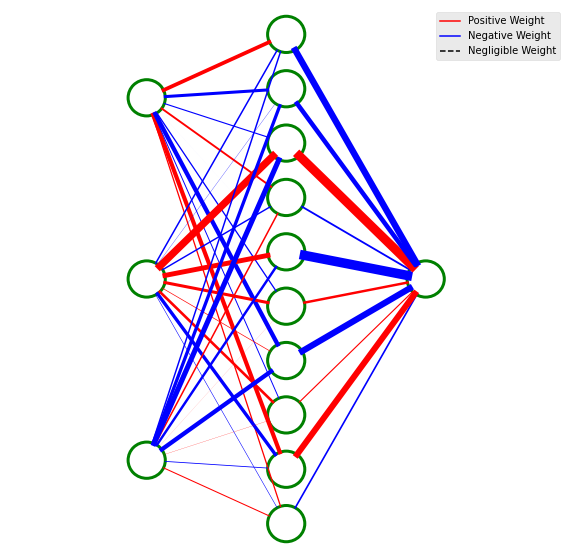

In [38]:
plt.close('all')
plt.style.use('ggplot')
radius = 1
RANGE = clf.hidden_layer_sizes[0]*radius*3
HORIZONTAL_SPACE = RANGE/(clf.n_layers_+1)

fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True)
ax.set_xlim((0, RANGE))
ax.set_ylim((0, RANGE))
ax.axis('off')

inputs = []
hidden_layers = []
outputs = []

# plot input layer
for i in range(clf.n_features_in_):
    neuron = Circle((HORIZONTAL_SPACE, (RANGE/clf.n_features_in_)/2 + i*RANGE/clf.n_features_in_),
        radius, fill=False, linewidth=3, color='g'
    )
    inputs.append(neuron)
    ax.add_patch(neuron)

# plot hidden layer(s)
no_hidden_layers = clf.n_layers_ - 2 # -2 for input & output layer
for i in range(no_hidden_layers):
    layer = []
    layer_size = clf.hidden_layer_sizes[i]
    for j in range(layer_size):
        neuron = Circle((HORIZONTAL_SPACE*(i+2), (RANGE/layer_size)/2 + j*RANGE/layer_size),
            radius, fill=False, linewidth=3, color='g'
        )
        layer.append(neuron)
        ax.add_patch(neuron)
    hidden_layers.append(layer)

    # if first hidden layer, use inputs, otherwise use previous layer
    previous_layer = None
    if i == 0:
        previous_layer = inputs
    else:
        previous_layer = hidden_layers[i-1]

    for j in range(layer_size):
        for k in range(len(previous_layer)):
            ax.add_line(
                create_line(
                    previous_layer[k],
                    layer[j],
                    clf.coefs_[i][k, j],
                    radius,
                )
            )

# plot output layer
for i in range(clf.n_outputs_):
    neuron = Circle((HORIZONTAL_SPACE*(clf.n_layers_), (RANGE/clf.n_outputs_)/2 + i*RANGE/clf.n_outputs_),
        radius, fill=False, linewidth=3, color='g'
    )
    outputs.append(neuron)
    ax.add_patch(neuron)

for i in range(clf.n_outputs_):
    for j in range(layer_size):
        ax.add_line(
            create_line(
                hidden_layers[no_hidden_layers-1][j],
                outputs[i],
                clf.coefs_[len(clf.coefs_)-1][j],
                radius,
            )
        )

ax.legend(handles=custom_legend())

plt.show()